Vinay Chandra, Jack Wooley, and Matt Palmer <br>
ECEN 758 <br>
11.22.23

In [2]:
import warnings
warnings.filterwarnings("ignore")

### These functions here are for loading the dataset

In [3]:
from torchvision.datasets.mnist import FashionMNIST
from torch.utils.data import DataLoader, random_split
from torch import manual_seed
from torchvision.transforms import ToTensor, Compose, Normalize

def get_dataloaders():
    # set random seed so that all splits from train/val will be the same
    manual_seed(64)
    transform = Compose([ToTensor(),
                         Normalize((0.5), (0.5))])

    dataset_60k = FashionMNIST(root='data', 
                           train=True,  # setting this parameter equal to True loads the train dataset, and False will load the test one
                           download=True,  # only downloads the data if you don't already have it
                           transform=transform  # necessary to load a tensor object and not an image object
                           )

    # Split the data into train and val sets (50k/10k split to match the 10k test set)
    train_set, val_set = random_split(dataset_60k, [50000, 10000])

    # Create dataloaders for the train and val sets
    train_loader = DataLoader(train_set, batch_size=32)
    val_loader = DataLoader(val_set, batch_size=32)

    # load the test set
    test_dataset = FashionMNIST(root='data', 
                           train=False,  # set to False to download the test set
                           download=True,
                           transform=transform
                           )
    
    # test dataloader
    test_loader = DataLoader(test_dataset, batch_size=32)

    return train_loader, val_loader, test_loader


def get_tabular_data():  # in case we decide to do any traditional ML stuff, we can have a regular data matrix (n x 784)
    """Return train/test dataset in a matrix format (n x 784), with a return statement like the sklearn train_test_split function (X_train, X_test, y_train, y_test).
    """

    manual_seed(64)
    transform = Compose([ToTensor(),
                         Normalize((0.5), (0.5))])

    dataset_60k = FashionMNIST(root='data', 
                           train=True,  # setting this parameter equal to True loads the train dataset, and False will load the test one
                           download=False,  # only downloads the data if you don't already have it
                           transform=transform  # necessary to load a tensor object and not an image object
                           )

    train_data = dataset_60k.data.reshape(60000, 784)
    train_labels = dataset_60k.targets

    # load the test set
    test_dataset = FashionMNIST(root='data', 
                           train=False,  # set to False to download the test set
                           download=False,
                           transform=transform
                           )
    
    test_data = test_dataset.data.reshape(10000, 784)
    test_labels = test_dataset.targets
    
    return train_data, train_labels, test_data, test_labels


# labels for the classes
label_dict = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}


In [16]:
from data_loader_utility import get_tabular_data, label_dict, get_dataloaders

In [3]:
# %pip install scikit-image

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import entropy
from skimage import feature


In [5]:
train_data, train_labels, test_data, test_labels = get_tabular_data()

In [6]:
reshaped_X_train = train_data.reshape(-1,784)
reshaped_y_train = train_labels.reshape(-1,1)
reshaped_X_test = test_data.reshape(-1,784)
reshaped_y_test = test_labels.reshape(-1,1)
df_data = np.append(reshaped_X_train,reshaped_y_train,axis = 1)
df = pd.DataFrame(df_data, columns=[f"pixel_{i}" if i <= 783 else "label" for i in range(785)])
df.shape

(60000, 785)

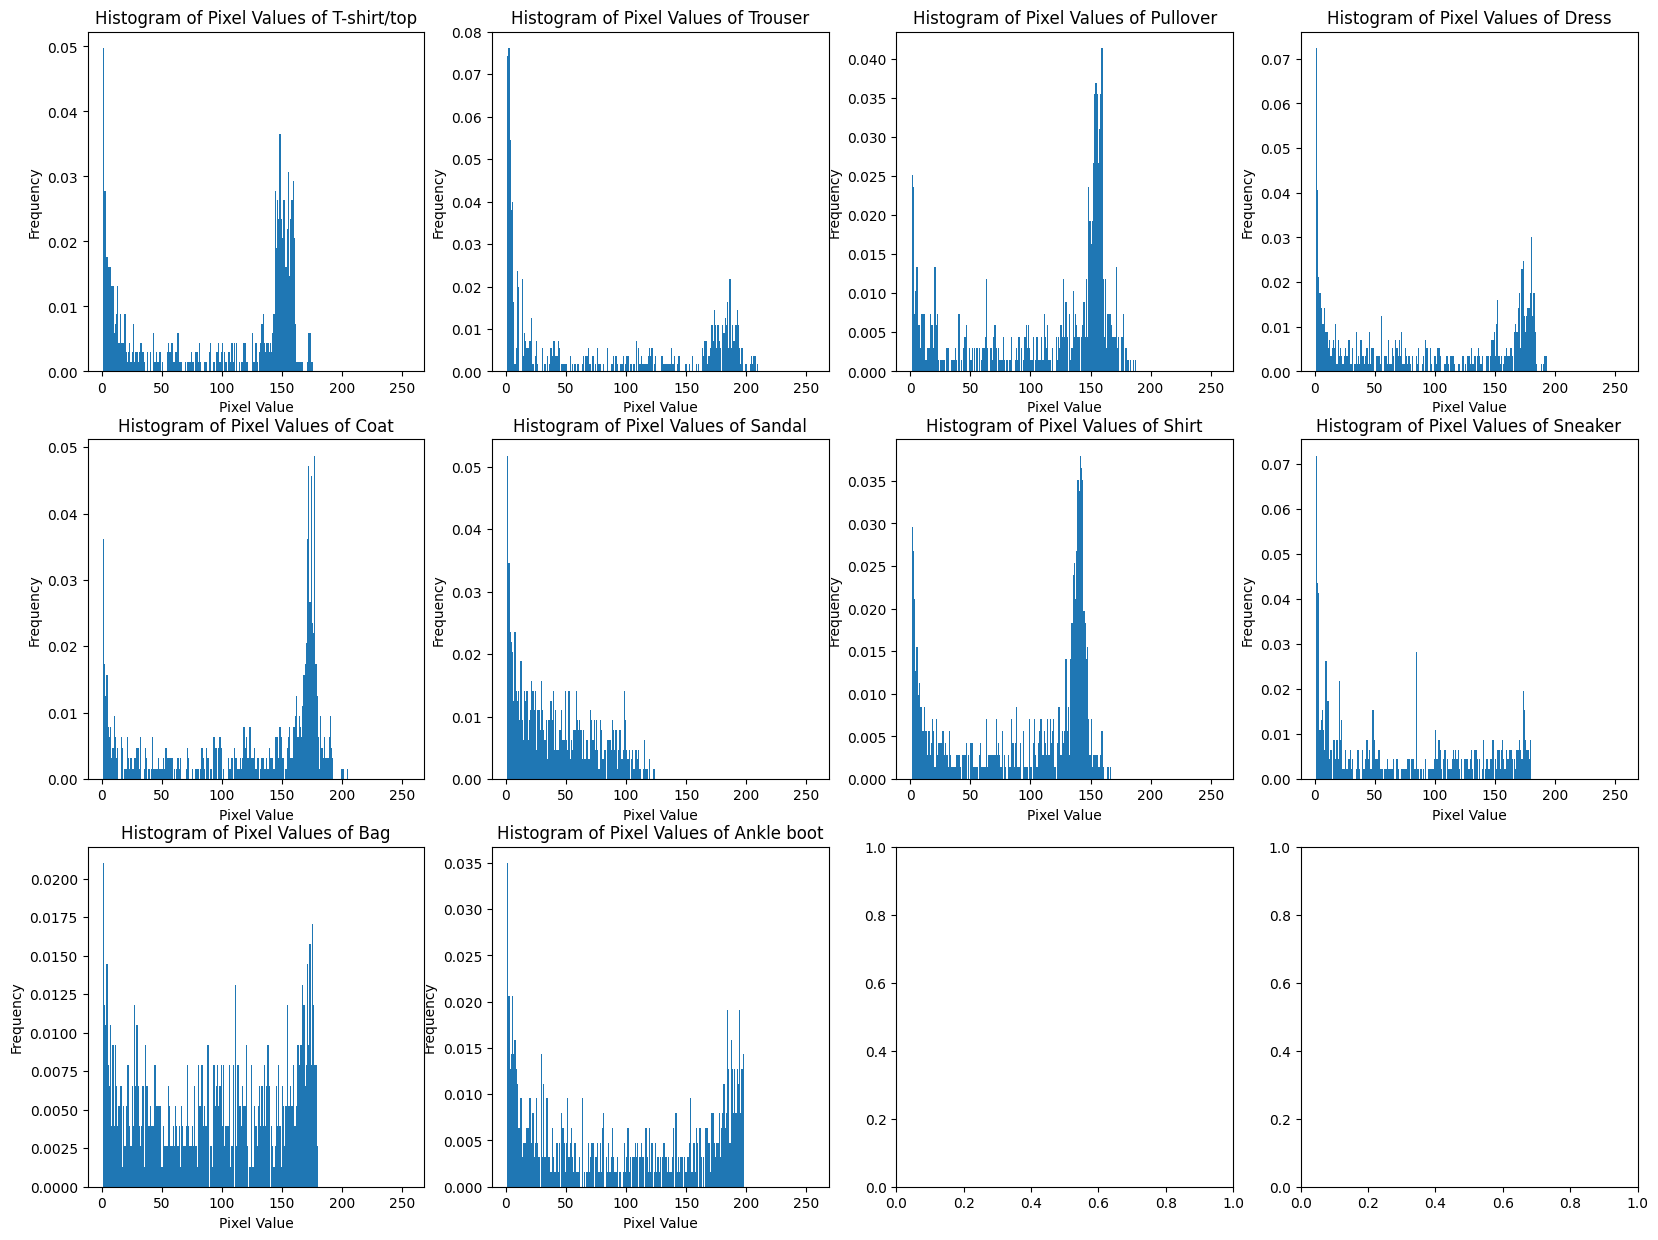

In [7]:
fig, ax1 = plt.subplots(3,4, figsize=(20,15))
ax1 = ax1.flatten()
for i in range(0,10):
    gray_image = df.loc[df['label'] == i].mean(axis=0).drop('label').values
    ax1[i].hist(gray_image, bins=255, range=[1, 256], density=True, cumulative=False)
    ax1[i].set_title(f'Histogram of Pixel Values of {label_dict[i]}')
    ax1[i].set_xlabel('Pixel Value')
    ax1[i].set_ylabel('Frequency')
plt.show()

* histogram of all classes except the class sandal exhibits bimodal (two peaks) distribution. A unimodal distribution is common in well-exposed images, while a bimodal distribution may indicate the presence of distinct foreground and background regions which can help classification.

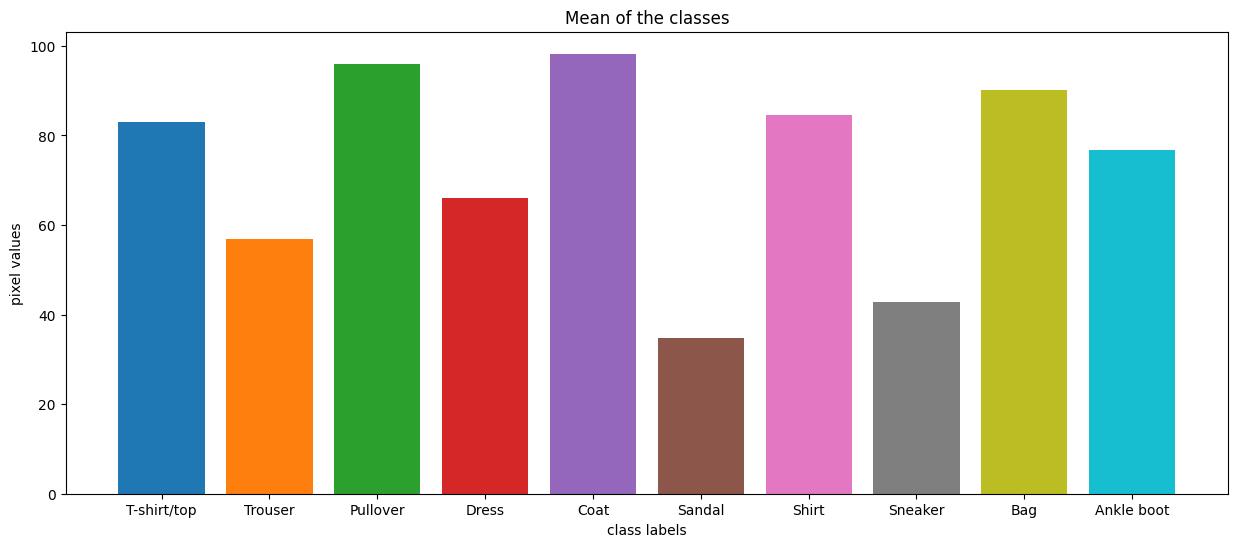

In [8]:
fig, ax2 = plt.subplots(1,1, figsize=(15,6))
for i in range(0,10):
    ax2.bar(label_dict[i],df.loc[df['label'] == i].mean(axis=0).drop('label').mean())
    ax2.set_xlabel("class labels")
    ax2.set_ylabel("pixel values")
    ax2.set_title("Mean of the classes")

* As the images are in grayscale, if the image have more pixes close to 255(white) the mean will be higher, in which case the classes pullover, coat, bag, T-shirt/top have higher mean as we calculated above.

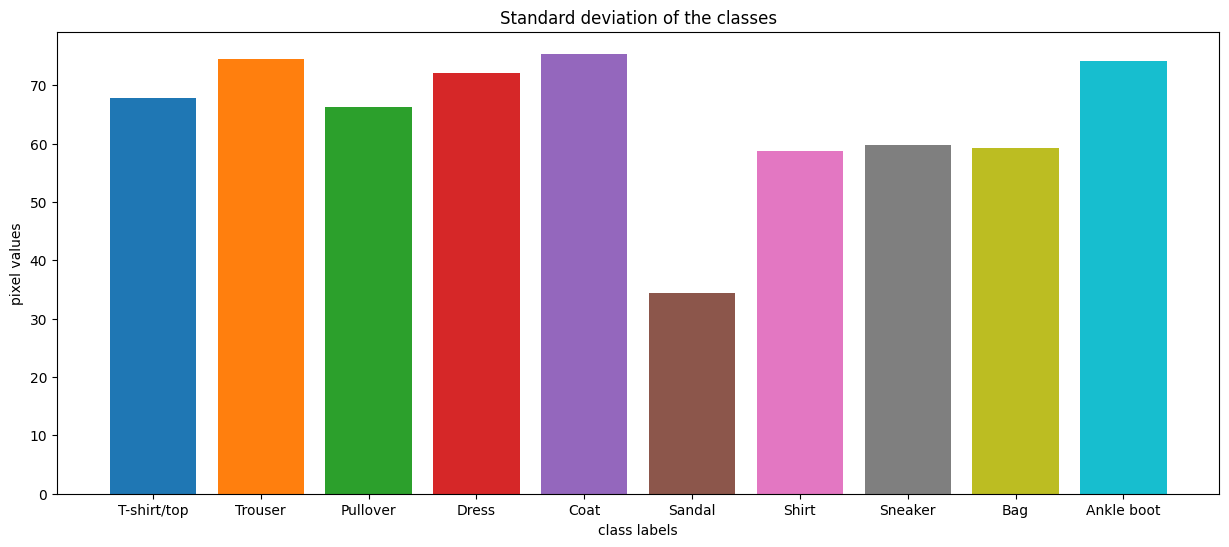

In [9]:
fig, ax3 = plt.subplots(1,1, figsize=(15,6))
for i in range(0,10):
    ax3.bar(label_dict[i],df.loc[df['label'] == i].mean(axis=0).drop('label').std())
    ax3.set_xlabel("class labels")
    ax3.set_ylabel("pixel values")
    ax3.set_title("Standard deviation of the classes")

* a higher standard deviation can indicate the presence of diverse textures or patterns, which may be useful in classification process. Also, a higher standard deviation is often associated with greater contrast. Images with higher contrast may contain more details and be visually more appealing.

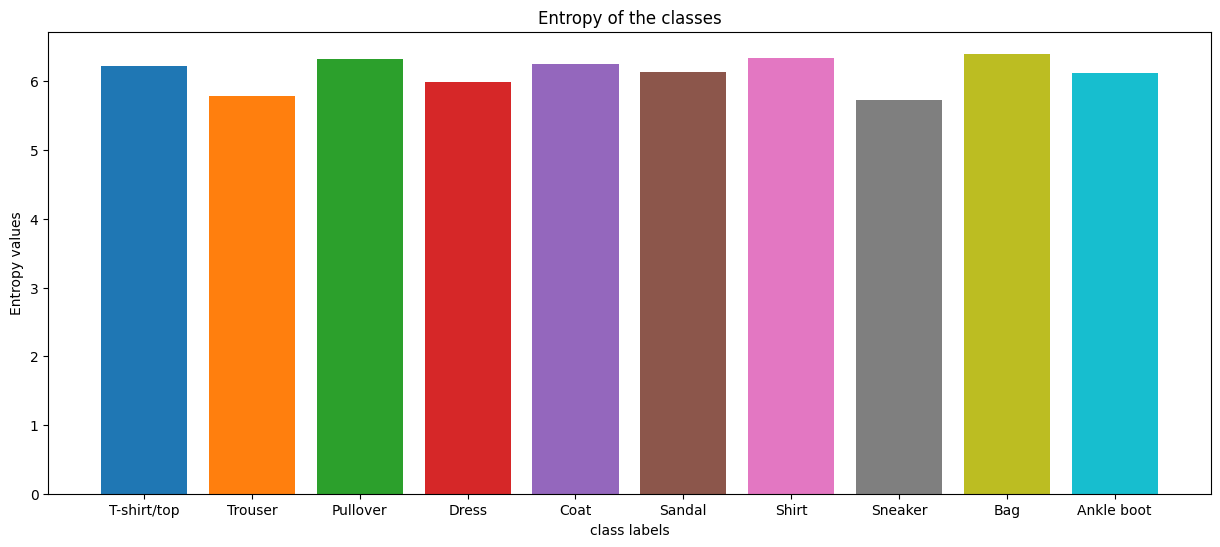

In [10]:
fig, ax4 = plt.subplots(1,1, figsize=(15,6))
for i in range(0,10):
    ax4.bar(label_dict[i],entropy(df.loc[df['label'] == i].mean(axis=0).drop('label').values))
    ax4.set_xlabel("class labels")
    ax4.set_ylabel("Entropy values")
    ax4.set_title("Entropy of the classes")

* Higher Entropy: If the entropy is high, it suggests that the pixel values in the image have a wide range of intensities, and there is a greater degree of variability or complexity in the image. This could be indicative of textures, patterns, or details in the image.

* Lower Entropy: A lower entropy value indicates a more uniform or predictable distribution of pixel intensities. This might occur in regions of the image with constant intensity, smooth gradients, or less information content.

* As we can see the entropy values for all our classes is high, which means there is a good detail in images or features that can be used for image classification

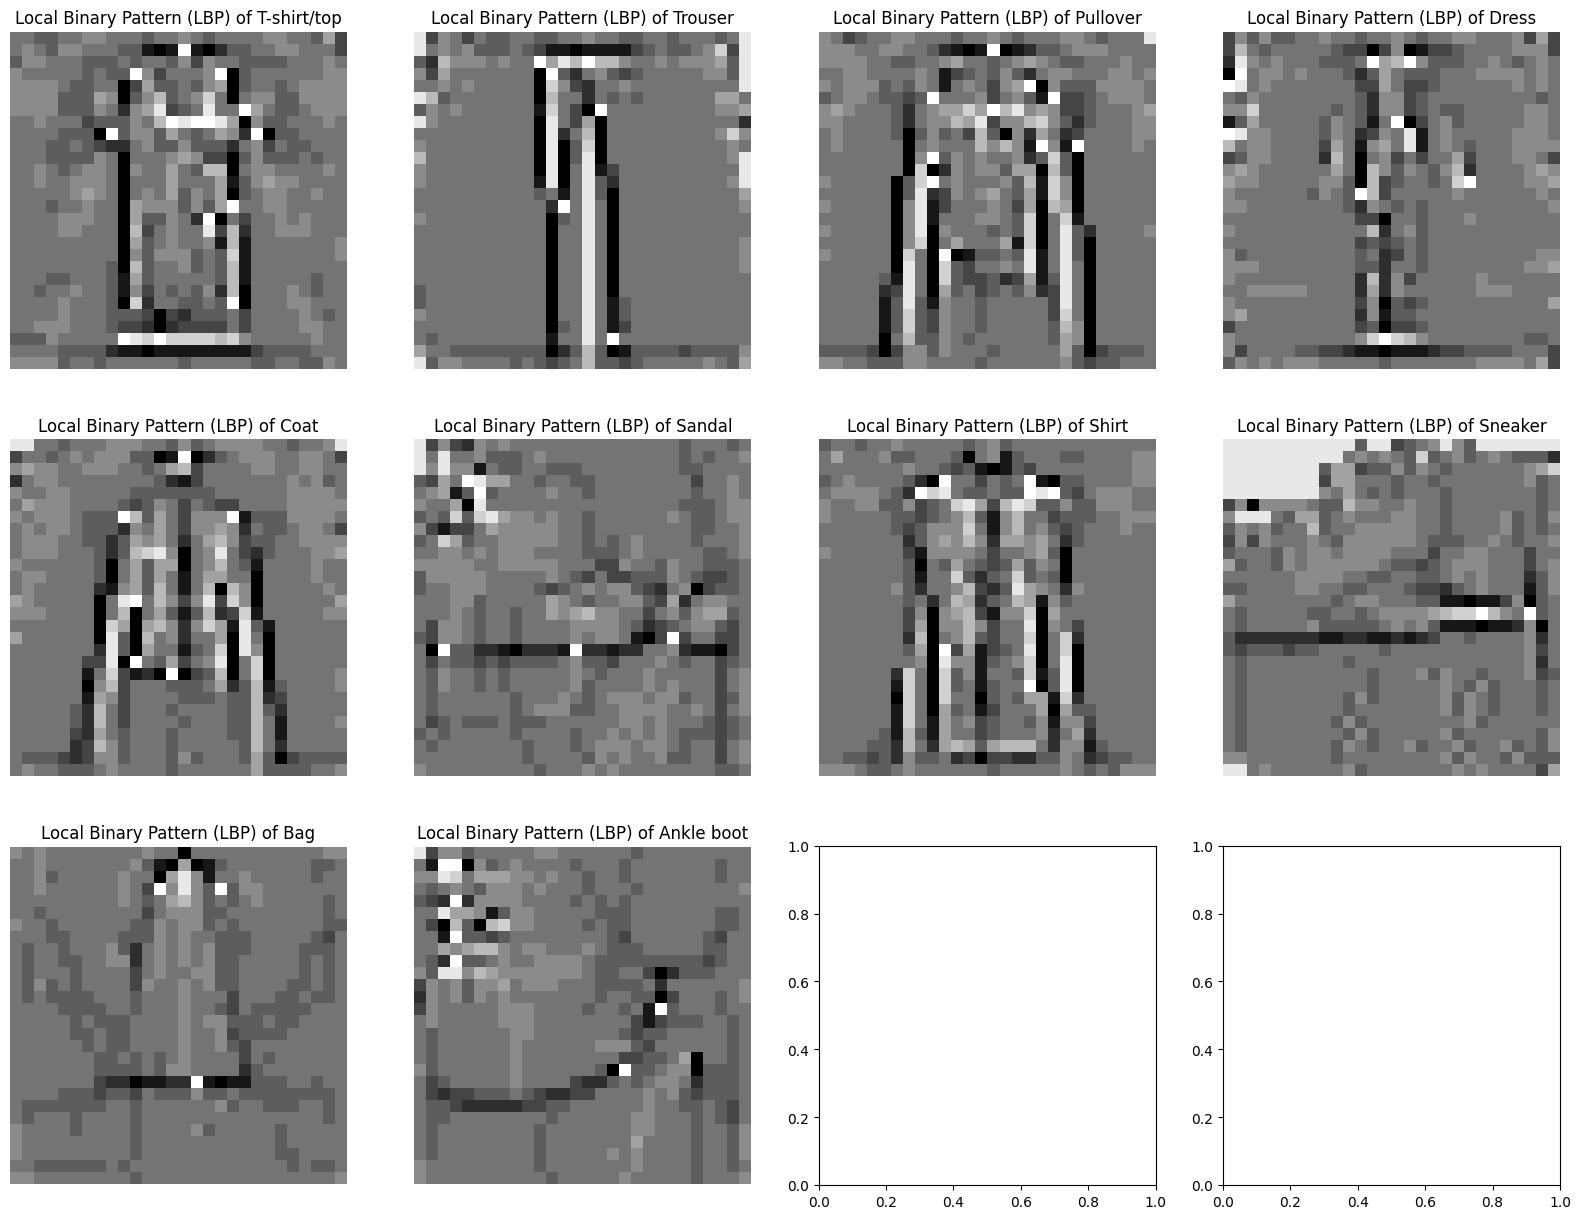

In [11]:
fig, ax5 = plt.subplots(3,4, figsize=(20,15))
ax5 = ax5.flatten()
for i in range(0,10):
    gray_image = df.loc[df['label'] == i].mean(axis=0).drop('label').values.reshape(28,28)
    lbp = feature.local_binary_pattern(gray_image, P=10, R=1, method='uniform')
    ax5[i].imshow(lbp, cmap='gray')
    ax5[i].set_title(f'Local Binary Pattern (LBP) of {label_dict[i]}')
    ax5[i].axis('off')
plt.show()

* Local Binary Pattern (LBP) is a texture descriptor used in computer vision and image analysis. It was introduced to capture local patterns and textures in an image. LBP describes the spatial structure of an image by considering the relationship between the intensity of a central pixel and its surrounding neighbors.

* Hence it is decribing the patterns we expect from our image classes according to thier structure

# Fitting machine learning models (KNN, Random forest, SVM) to the raw data 

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [66]:
knn = KNeighborsClassifier(n_neighbors = 3)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
svm = SVC(C=1.0, kernel='rbf', random_state=42)

for name, ml_model in zip(["KNN","Random forest", "SVM"],[knn,rf,svm]):
    ml_model.fit(reshaped_X_train, reshaped_y_train)
    y_pred_ml_model = ml_model.predict(reshaped_X_test)
    accuracy_ml_model = accuracy_score(reshaped_y_test, y_pred_ml_model)
    precision_ml_model = precision_score(reshaped_y_test, y_pred_ml_model, average='weighted')
    recall_ml_model = recall_score(reshaped_y_test, y_pred_ml_model, average='weighted')
    f1_score_ml_model = f1_score(reshaped_y_test, y_pred_ml_model, average='weighted')
    print(f"accuracy of {name} is {accuracy_ml_model} \nPrecision of {name} is {precision_ml_model}\nRecall of {name} is {recall_ml_model}\nF1-score of {name} is {f1_score_ml_model}\n")

accuracy of KNN is 0.8541 
Precision of KNN is 0.8575414622679564
Recall of KNN is 0.8541
F1-score of KNN is 0.8822648793630384

accuracy of Random forest is 0.876 
Precision of Random forest is 0.8748968341440737
Recall of Random forest is 0.876
F1-score of Random forest is 0.8822648793630384

accuracy of SVM is 0.8828 
Precision of SVM is 0.882309111843896
Recall of SVM is 0.8828
F1-score of SVM is 0.8822648793630384



# Fitting a CNN

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_dl, test_dl, val_dl = get_dataloaders()

In [14]:
# set up model structure
class HomemadeCNN(nn.Module):
    def __init__(self):
        super().__init__()

        # first convolution
        self.conv1 = nn.Conv2d(1, 28, kernel_size=3, stride=1, padding=1)  # review wht the different channels are (andrew ng)
        self.act1 = nn.ReLU()
        
        # maxpooling over 2x2 windows (reduces height/width by a factor of 2)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        # second convolution
        self.conv2 = nn.Conv2d(28, 14, kernel_size=3, stride=1, padding=1)  # default padding is 0, so we need to specify 1 to get the dimensions we want
        self.act2 = nn.ReLU()

        # maxpooling over 2x2 windows (reduces height/width by a factor of 2)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        # flatten into vectors
        self.flat = nn.Flatten()

        # linear, fully-connected layer
        self.fc4 = nn.Linear(14*7*7, 343)
        self.act4 = nn.ReLU()

        # dropout layer to avoid overfitting
        self.drop4 = nn.Dropout(0.2)  # drop out 20% of connections btwn neurons

        # linear, fully-connected layer
        self.fc5 = nn.Linear(343, 10)


    def forward(self, x):
        # input shape: 32x1x28x28 (dimensions are BATCH_SIZExNUM_CHANNELSxHEIGHTxWIDTH)
        x = self.act1(self.conv1(x))
        # shape: 32x28x28x28
        x = self.pool1(x)
        # shape: 32x28x14x14
        x = self.act2(self.conv2(x))
        # shape: 32x14x14x14
        x = self.pool2(x)
        # shape: 32x14x7x7
        
        x = self.flat(x)
        # x = torch.flatten(x)

        # shape: 32x686 (32 vectors of length 686)
        x = self.act4(self.fc4(x))
        x = self.drop4(x)
        # shape: 32x343
        x = self.fc5(x)
        # shape: 32x10 (class labels)
        return x

# trained = HomemadeCNN()
# trained.load_state_dict(torch.load('homemademodel_normalized.pth'))
# trained.eval()

In [22]:
model_ = HomemadeCNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_.parameters(), lr=0.001, momentum=0.9)

val_accuracies = []
train_accuracies = []
train_losses = []
val_losses = []
n_epochs = 30
for epoch in range(n_epochs):

    train_acc = 0
    train_count = 0
    model_.train()
    for inputs, labels in train_dl:
        # forward, backward, and then weight update
        labels = labels.to(device)
        inputs = inputs.to(device)
        train_y_pred = model_(inputs)
    
        loss = loss_fn(train_y_pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_acc += (torch.argmax(train_y_pred, 1) == labels).float().sum()
        train_count += len(labels)
    train_losses.append(loss.item())
    train_acc /= train_count
    train_accuracies.append(train_acc.item() * 100)
    print("Epoch %d: model accuracy (train) %.2f%%" % (epoch, train_acc*100))

    # validation
    # val accuracy
    val_acc = 0
    val_count = 0
    model_.eval()
    for inputs, labels in val_dl:
        val_labels = labels.to(device)
        inputs = inputs.to(device)
        val_y_pred = model_(inputs)

        val_loss = loss_fn(val_y_pred, labels)
        val_acc += (torch.argmax(val_y_pred, 1) == labels).float().sum()
        val_count += len(labels)
    val_losses.append(val_loss.item())
    val_acc /= val_count
    val_accuracies.append(val_acc.item() * 100)
    print("Epoch %d: model accuracy (val) %.2f%%" % (epoch, val_acc*100))

Epoch 0: model accuracy (train) 69.86%
Epoch 0: model accuracy (val) 77.22%
Epoch 1: model accuracy (train) 81.37%
Epoch 1: model accuracy (val) 81.51%


KeyboardInterrupt: 

In [19]:
val_acc

tensor(0.7656)

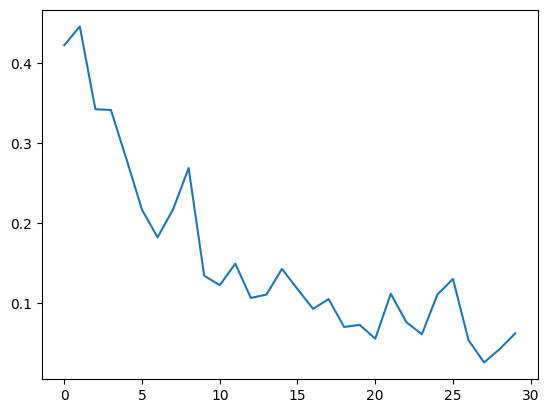

In [ ]:
# plt.title('Training and validation accuracies')
# plt.plot(train_accuracies)
# plt.plot(val_accuracies)
plt.plot(losses)